**Note:** Most of this notebook was originally coded in Spell, but due to the length at some of these models that were running, I switched over to Colab for the finishing touches. I wanted to take advantage of its TPU/GPU computing power. 

Many of these models are saved in the directory of this project. 

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


This is the notebook for some data exploration, feature selection, and model experimentation to predict which hallmark genes are associated with which tumor stage of cancer. 

In [0]:
import numpy as np
import pandas as pd
import gzip, shutil

In [0]:
path = '/content/drive/My Drive/MyDrive/Cancer Analysis/'
file_x = path + 'X.csv'
file_y = path + 'y.csv'
rnaseq_x = pd.read_csv(file_x)
tumor_y = pd.read_csv(file_y)

In [4]:
rnaseq_x.head()

,Unnamed: 0,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADACL2,AADACL3,AADACL4,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,1032,0,558,0,0,0,1364,25,1068,690,3207,0,341,848,7024,1225,144,48,1542,62,1535,155,65,0,0,2,1151,1678,93,109,...,902,1335,26,229,2,39,60,134,95,0,24,152,112,0,405,451,0,95,2,127,0,101,136,277,181,413,210,305,213,464,25,274,795,19,500,3173,891,511,4,7
1,tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,903,0,431,0,1,0,10365,156,1058,542,3148,1,682,885,8495,977,160,450,2002,17,11220,22,23,1,19,2,1249,1126,74,50,...,682,1403,95,155,1,46,68,104,323,1,67,366,145,1,553,583,2,47,2,268,0,143,138,874,173,153,127,677,542,629,69,633,1154,72,1001,5302,756,861,7,483
2,tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,773,0,131,0,0,0,6959,479,523,510,2211,0,483,349,3542,806,165,3014,842,24,12577,36,30,1,26,0,3133,2186,70,25,...,2211,1211,56,113,0,33,45,78,174,0,6,242,99,4,417,190,0,49,2,138,0,125,119,9,196,183,91,399,177,287,47,1220,1134,13,1290,3220,861,524,15,84
3,tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,722,0,706,0,0,0,6782,36,394,1568,1739,0,493,462,5918,748,184,1389,825,14,9671,55,109,0,4,7,1748,246,452,14,...,809,969,62,93,1,31,41,70,71,1,8,407,126,2,357,403,0,139,3,255,0,109,68,64,330,323,115,433,330,451,19,286,1151,10,942,3093,1340,344,3,3
4,tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,828,0,94,1,0,0,7106,616,614,536,1936,0,819,456,6088,815,253,698,894,43,23069,19,35,0,13,2,2885,1129,110,39,...,1312,1684,90,168,1,119,98,119,593,0,10,298,155,1,385,239,0,55,2,198,0,86,94,2,234,180,103,642,137,100,42,1000,1632,5,1381,2903,576,666,3,120


In [5]:
tumor_y.head()

,Unnamed: 0,tumor_stage
0,tcga-2v-a95s-0,ii
1,tcga-2y-a9gs-1,not_reported
2,tcga-2y-a9gt-2,i
3,tcga-2y-a9gu-3,i
4,tcga-2y-a9gv-4,i


Let's fix up the dataset a bit before diving further. We'll just rename the "Unnamed: 0" to "bcr_patient_barcode" to better reflect the data we're working with. We'll also set it to the index. 

In [0]:
#Renaming the Unnamed: 0 column to bcr_patient_barcode and setting that 
#to be the index for both datasets 
rnaseq_x = rnaseq_x.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
rnaseq_x = rnaseq_x.set_index('bcr_patient_barcode')
tumor_y = tumor_y.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
tumor_y = tumor_y.set_index('bcr_patient_barcode')

In [7]:
rnaseq_x.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADACL2,AADACL3,AADACL4,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,1032,0,558,0,0,0,1364,25,1068,690,3207,0,341,848,7024,1225,144,48,1542,62,1535,155,65,0,0,2,1151,1678,93,109,1219,...,902,1335,26,229,2,39,60,134,95,0,24,152,112,0,405,451,0,95,2,127,0,101,136,277,181,413,210,305,213,464,25,274,795,19,500,3173,891,511,4,7
tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,903,0,431,0,1,0,10365,156,1058,542,3148,1,682,885,8495,977,160,450,2002,17,11220,22,23,1,19,2,1249,1126,74,50,1079,...,682,1403,95,155,1,46,68,104,323,1,67,366,145,1,553,583,2,47,2,268,0,143,138,874,173,153,127,677,542,629,69,633,1154,72,1001,5302,756,861,7,483
tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,773,0,131,0,0,0,6959,479,523,510,2211,0,483,349,3542,806,165,3014,842,24,12577,36,30,1,26,0,3133,2186,70,25,2316,...,2211,1211,56,113,0,33,45,78,174,0,6,242,99,4,417,190,0,49,2,138,0,125,119,9,196,183,91,399,177,287,47,1220,1134,13,1290,3220,861,524,15,84
tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,722,0,706,0,0,0,6782,36,394,1568,1739,0,493,462,5918,748,184,1389,825,14,9671,55,109,0,4,7,1748,246,452,14,1269,...,809,969,62,93,1,31,41,70,71,1,8,407,126,2,357,403,0,139,3,255,0,109,68,64,330,323,115,433,330,451,19,286,1151,10,942,3093,1340,344,3,3
tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,828,0,94,1,0,0,7106,616,614,536,1936,0,819,456,6088,815,253,698,894,43,23069,19,35,0,13,2,2885,1129,110,39,2132,...,1312,1684,90,168,1,119,98,119,593,0,10,298,155,1,385,239,0,55,2,198,0,86,94,2,234,180,103,642,137,100,42,1000,1632,5,1381,2903,576,666,3,120


In [8]:
tumor_y.head()

,tumor_stage
bcr_patient_barcode,
tcga-2v-a95s-0,ii
tcga-2y-a9gs-1,not_reported
tcga-2y-a9gt-2,i
tcga-2y-a9gu-3,i
tcga-2y-a9gv-4,i


In [9]:
print("RNA sequences features length: {}".format(len(rnaseq_x.columns)))
print("Tumor stages length: {}".format(len(tumor_y)))

RNA sequences features length: 20501
Tumor stages length: 423


Because the counts of the RNA sequence are hard to interpret, I decided to change them into percentages to get a better reading of which RNA sequence is more significant to each patient. I decided to use the MinMaxScaler in order to achieve this. 


For the first iteration of this feature selection process, I opted to use the Random Forest Classifier's (RFC) feature importance attribute in order to reduce dimensionality on the data. As we can see, we have over 20,000 genes to sort through, so I need to find an efficient way of evaluating the genes that actually matter. Therefore, I'll preemtively train the Random Forest Classifier on the scaled dataset. I'll later on use other models to compare RFC in another hyper-parameter optmization phase. 

That being said, the next step is the hyper-parameter optimization phase in this process. I opted to use a Pipeline and to use Randomized Search in order to find the best model with the best scoring. Why Randomized Search over Grid Search? I'd like to select a random set of values instead of going through every combination for this step of the process. We're focusing on feature selection and not model evaluation at this stage, so I opted to speed up the process here for optimization at this stage of the process. I'll be looking observing and tuning all of the best values for each paramater in the RFC. In order to achieve a smooth process for the model evaluation later on, I created a "SwitchClassifier" class to switch between the other models.

Note, we'll be using the grid search throughout this process of feature selection and model selection/evaluation. This way, we can always get the best model at each iteration, and we can also compare all of our models at the end of this process. 

In [0]:
from sklearn.base import BaseEstimator 
from sklearn.naive_bayes import MultinomialNB

class SwitchClassifier(BaseEstimator):
    
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier 
    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 
    
    def predict(self, X, y=None):
        self.classifier.predict(X)
    
    def predict_proba(self, X, y=None):
        return self.classifier.predict_proba(X)
    
    def score(self, X, y=None):
        return self.classifier.score(X, y)
            

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split

pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=110, num=11)],
         'classifier__bootstrap': [True, False]}
    

rnaseq_x_train, rnaseq_x_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x, np.array(tumor_y),
                                                                                 random_state=np.random.seed(0))

In [0]:
rscv = RandomizedSearchCV(pipe, params, n_iter=100, verbose=2, cv=3, random_state=np.random.seed(0), n_jobs=-1)
rscv.fit(rnaseq_x_train, tumor_y_train)

In [0]:
import pickle
#random_forest_best = rscv.best_params_['classifier']
#saving the model for later use. 
filename = path + 'random_forest_best.sav'
#rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))

In [12]:
rfcb_loaded

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

So, as we can see from above, the best model that was choosen have these hyperparameters. We'll use this RFC model in the select SelectFromModel process in order to do our feature selection. I'll be choosing the median as the threshold (which is how much features the SelectFromModel algorithm considers when selecting features). The median is a considerable threshold since it'll just basically choosing the lower half or higher half of the features in the dataset.

As stated previously, we'll be doing a grid search on the Multionomial Naive Bayes classifier, SGD Classifier, and RFC (using the same hyperparameters that was chosen from the randomized search).

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV


sfm = SelectFromModel(rfcb_loaded, threshold='median')
sfm.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train_sfm = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test_sfm = sfm.transform(rnaseq_x_test)

def grid_search_process(df_x_train, df_y_train):
    pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                     ('classifier', SwitchClassifier())])

    param_grid = [ 
            {'classifier': [MultinomialNB()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}, 
            {'classifier': [SGDClassifier()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
             'classifier__penalty': ['l2', 'l1', 'elasticnet'], 
             'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
            {'classifier': [RandomForestClassifier()], 
             'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
             'classifier__max_features': ['sqrt'],
             'classifier__min_samples_split': [2],
             'classifier__min_samples_leaf': [1],
             'classifier__n_estimators': [200], 
             'classifier__max_depth': [50],
             'classifier__bootstrap': [False]}
        ]

    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(df_x_train, df_y_train)
    return grid_search

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [19]:
grid_search_1 = grid_search_process(rnaseq_x_important_train_sfm, tumor_y_train)
grid_search_1_best_parameters = grid_search_1.best_params_['classifier']
grid_search_1_cv_score = grid_search_1.best_score_*100
grid_search_1_test_set_score = grid_search_1.score(rnaseq_x_important_test_sfm, tumor_y_test)*100

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [20]:
print("Best parameters:\n{}\n".format(grid_search_1_best_parameters))
print("Best cross-validation score: {:.2f}%".format(grid_search_1_cv_score))
print("Test-set score: {:.2f}%".format(grid_search_1_test_set_score))

Best parameters:
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Best cross-validation score: 47.65%
Test-set score: 45.28%


In [0]:
clf_best_1 = grid_search_1.best_params_['classifier']
filename = path + 'clf_best_1.sav' #saving model
clfb_saved_1 = pickle.dump(clf_best_1, open(filename, 'wb'))
clfb_loaded_1 = pickle.load(open(filename, 'rb'))

As we can see, the grid search chose the RFC with all of these hyperparameters as its best forming model, but these cross validation and test set scares aren't looking great. We can also visualize a confusion matrix from our model to see true/actual labeling vs. the predicted labeling.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


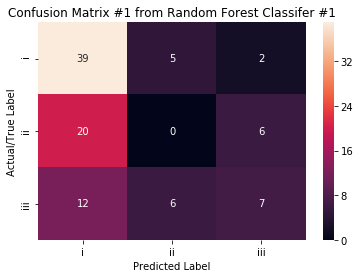

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


clfb_loaded_1.fit(rnaseq_x_important_train_sfm, tumor_y_train)
tumor_y_pred = clfb_loaded_1.predict(rnaseq_x_important_test_sfm)

def plot_matrix(y_test, y_pred, iter_n, model_name):
  seed = np.random.seed(0)
  matrix = confusion_matrix(y_test, y_pred, labels=['i', 'ii', 'iii'])
  sns.heatmap(matrix, annot=True, xticklabels=['i', 'ii', 'iii'], yticklabels=['i', 'ii', 'iii'])
  plt.ylabel('Actual/True Label')
  plt.xlabel('Predicted Label')
  plt.title('Confusion Matrix #{} from {}'.format(str(iter_n), model_name))

plot_matrix(tumor_y_test, tumor_y_pred, 1, "Random Forest Classifer #1")

As we see from our confusion matrix here, only 39 out of the 71 classes were labeled correctly for cancer stage 1, 0 out of 11 for cancer stage 2, and 6 out 16 for cancer stage 3. This is a great visual of how well (or not) our model is currently doing.

Let's head-on to our next phase of feature selection and model selection/evaluation to see if we can improve from there. 

We'll be using the SelectFromPercentile algorithm, which is a little similar to SelectFromModel. It's pretty self-explanatory, as our threshold will be chosen by the percent amount of features it chooses. Because we have 20,000+ features, let's choose the top 10% of features.

In [0]:
from sklearn.feature_selection import SelectPercentile 


sp = SelectPercentile(percentile=10)
sp.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train_sp = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test_sp = sfm.transform(rnaseq_x_test)

In [27]:
grid_search_2 = grid_search_process(rnaseq_x_important_train_sp, tumor_y_train)
grid_search_2_best_parameters = grid_search_2.best_params_['classifier']
grid_search_2_cv_score = grid_search_2.best_score_*100
grid_search_2_test_set_score = grid_search_2.score(rnaseq_x_important_test_sp, tumor_y_test)*100

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
print("Best parameters:\n{}\n".format(grid_search_2_best_parameters))
print("Best cross-validation score: {:.2f}%".format(grid_search_2_cv_score))
print("Test-set score: {:.2f}%".format(grid_search_2_test_set_score))

Best parameters:
SGDClassifier(alpha=1.0, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Best cross-validation score: 47.32%
Test-set score: 45.28%


In [0]:
clf_best_2 = grid_search_2.best_params_['classifier']
filename = path + 'clf_best_2.sav'
clfb_saved_2 = pickle.dump(clf_best_2, open(filename, 'wb'))
clfb_loaded_2 = pickle.load(open(filename, 'rb'))

The SGD classifier has beaten out the MultinomialNB and RFC models in this iteration this time around, but the test-set score is not looking great here. It does seem that reducing the features greatly improves our training (cross validation) score, but the model still suffers from poor generalization, meaning that we cannot rely too much on our training data for complete accuracy. This can just be consequence of the amount of features that we have in our RNA sequence dataset. 

Let's take a look at the confusion matrix this time around. 

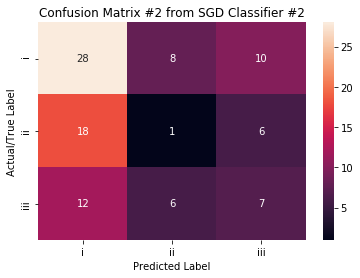

In [0]:
clfb_loaded_2.fit(rnaseq_x_important_train_sp, tumor_y_train)
tumor_y_pred = clfb_loaded_2.predict(rnaseq_x_important_test_sp)

plot_matrix(tumor_y_test, tumor_y_pred, 2, "SGD Classifier #1")

Definitely not an improvement from last time. We're starting to feel the weight of having so many features in the dataset in general.

Since the test-set accuracy scores that we're getting through the last two methods of feature extraction are below 50%, I'll be shifting strategies in how to extract features to get the best model predictive score. I'll now stick with using the hallmark gene dictionary to extract the features for each hallmark gene using the "feature selector" function I'll be creating. Then, I will be using the RandomForestClassifier model that I saved earlier to extract the best features. I'll be introducing Permutation Importance to visualize the best features per hallmark gene so we can see which features have a higher percentage of importance. 


In [0]:
!pip install eli5

In [0]:
import pickle 
hallmark_dict = pickle.load(open(path + 'hallmarks_of_cancer_geneset_dictionary.pkl','rb'))

In [0]:
def feature_selector(features_to_select, df): 
    new_df = pd.DataFrame()
    for features in features_to_select: 
        if features in df.columns: 
            new_df[features] = df[features].values
    return new_df

In [0]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

def train_hallmark(hallmark_gene, hallmark_arr, flag=False):
  new_df = feature_selector(hallmark_arr, rnaseq_x)
  new_df.name = hallmark_gene 
  new_df_train, new_df_test, tumor_y_train, tumor_y_test = train_test_split(new_df, np.array(tumor_y), random_state=np.random.seed(0))
  rfcb_model = rfcb_loaded.fit(new_df_train, tumor_y_train)
  perm = PermutationImportance(rfcb_model, random_state=1).fit(new_df_test, tumor_y_test)
  print(new_df.name + ":\n")
  perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=new_df_test.columns.tolist(), top=50))
  if flag == True:
    return display(eli5.show_weights(perm, feature_names=new_df_test.columns.tolist(), top=50))
  else: 
    return perm_df
  

#let's display the first trained dataset and their weights from PermutationImportance
for hallmark_gene, hallmark_arr in list(hallmark_dict.items())[:1]: 
  train_hallmark(hallmark_gene, hallmark_arr, True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expe

HALLMARK_ADIPOGENESIS:



Weight,Feature
0.0226 ± 0.0151,SDHC
0.0189 ± 0.0000,DHRS7
0.0151 ± 0.0092,ACO2
0.0151 ± 0.0092,PEMT
0.0132 ± 0.0092,NMT1
0.0132 ± 0.0192,CYP4B1
0.0132 ± 0.0092,ALDH2
0.0113 ± 0.0141,ATP1B3
0.0113 ± 0.0141,TALDO1
0.0113 ± 0.0141,STAT5A


Let's explain what is happening with the permutation importances. The weights are calculated by dividing the estimated error score from the permutation and the original feature importance score. So, the weights that are less than zero (not pictured here due to multiple features) can be discarded as it signifies that these features that the algorithm calculated are not considered important. In other words, for the hallmark gene Adipogenesis, the most important gene is SDHC. 

Therefore, I'll discard any features that are NOT in the green, meaning that the features with weights greater than 0 as well as choosing the top 10 features per hallmark gene from the permutation algorithm in order to get the genes are more concentrated in green.

In [0]:
hallmark_columns = []
hallmark_mapped_features = {}
for hallmark_gene, hallmark_arr in hallmark_dict.items():
    perm_df = train_hallmark(hallmark_gene, hallmark_arr, False)
    filtered_perm_df = perm_df.head(10)
    hallmark_columns.append(list(filtered_perm_df['feature']))

In [0]:
import itertools
hallmark_columns = list(itertools.chain.from_iterable(hallmark_columns))
hallmark_columns_unique = list(set(hallmark_columns))
print("{} => {} => {}".format(len(rnaseq_x.columns), len(hallmark_columns), len(hallmark_columns_unique)))

20501 => 500 => 453


Now, I've gone from the original 20,000+ features to the processed  features from each hallmark gene which resulted in 453 features. We'll now select the features and start to train the new dataframe using the grid_search_process function. Afterwards, we'll compare the accuracy scores from all feature selection processes. 

In [31]:
#rnaseq_x_important_hallmark_df = feature_selector(hallmark_columns_unique, rnaseq_x)
#saving dataframe as the pre-processing took close to an hour to finish 
#rnaseq_x_important_hallmark_df.to_csv(path + 'rnaseq_x_important_hallmark.csv')
rnaseq_x_important_hallmark_df = pd.read_csv(path + 'rnaseq_x_important_hallmark.csv')

#We'll be using the MinMaxScaler in the grid_search_process function 
rnaseq_x_important_hallmark_df = rnaseq_x_important_hallmark_df.rename(columns={'Unnamed: 0': 'index'})
rnaseq_x_important_hallmark_df = rnaseq_x_important_hallmark_df.set_index('index')
rnaseq_x_important_hallmark_df.head()

,GPC3,NDRG2,CDK2,IL33,DAP3,PEX16,PDP1,FNTA,ADCYAP1,EPCAM,KLF6,TSN,FOXN3,QDPR,LONP2,TPD52L1,KRT13,TAF12,GBF1,CPB2,ADAM9,IL2RB,CNP,JUNB,TALDO1,SAP30,BGN,EFNA3,ST14,GLA,NAP1L1,PLK1,EZR,C5AR1,CTSE,ELF4,BIRC5,IL1B,MMD,NINJ1,...,PEX14,CDC6,FDFT1,RBM14,TJP1,TPM4,FETUB,RAB9A,ATF5,HSPD1,SLC6A6,FZD7,CAT,RABGAP1,HPN,GBP6,KRT19,TGFBRAP1,TTK,ARPP19,FLNA,NADSYN1,DCK,HDAC2,TOP2A,COPA,SLC30A10,METAP1,S100A11,NAT1,NOTCH1,PSME2,GLO1,ECH1,CCNA2,ATXN2,IFI30,LLGL1,PSMC4,GPX3
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29023,1835,678,182,4281,1180,79,1353,0,50,2411,2549,891,895,1149,176,0,659,1581,5460,1015,857,3209,5927,4893,275,2503,45,1010,725,6112,403,2694,258,3,143,460,30,412,1370,...,488,371,2854,1161,1122,3588,196,364,993,13569,282,76,1985,483,8101,95,15,57,165,1684,2956,1792,356,979,1220,6154,358,856,2280,102,507,13171,1977,7822,328,820,12608,239,3913,1084
1,5368,4926,538,67,3258,981,128,793,1,97,1621,1810,2327,1271,5480,814,6,570,1500,9035,1939,131,3836,1118,12389,114,4786,47,1396,681,4577,820,2347,149,9,111,340,30,673,1289,...,758,477,3306,1101,3769,2884,5509,358,22138,16231,171,96,12660,477,6470,3,157,157,417,3903,11688,1001,289,1175,2550,9703,2267,689,1091,127,485,3434,2577,8939,358,793,4781,360,2976,8670
2,75,5798,543,374,1447,734,71,879,4,14,7693,1477,1850,4679,3750,703,11,345,2724,40877,492,787,1992,2704,3827,132,3454,14,189,508,2079,47,3618,165,2,159,46,7,171,1779,...,835,264,2263,886,1576,2445,7735,342,18447,8313,338,41,17963,463,23996,5,88,99,26,1861,4939,1363,288,677,375,4997,996,637,917,336,939,4524,1873,7316,145,884,5346,243,2057,8634
3,15309,9133,207,156,4763,609,81,771,1,2099,1790,912,2591,5724,2432,747,2,384,3002,27276,529,103,2402,564,3278,36,1556,23,208,795,1605,382,2299,66,0,72,158,5,190,1477,...,700,561,856,715,1228,2242,1534,318,103801,11945,310,23,7423,325,28158,1,190,145,185,1449,2421,697,307,915,662,6613,2342,619,326,162,534,2214,1477,21545,604,735,2913,213,2991,9215
4,220,6742,375,165,2046,830,82,942,18,0,3446,1319,1935,3117,4030,629,0,391,2443,9786,815,294,2465,3881,3475,93,2385,22,308,253,2775,34,2179,408,0,89,33,27,286,2528,...,717,226,3147,754,2433,2083,5881,315,59297,8586,282,6,17639,665,15620,12,0,133,15,2433,3000,1086,154,762,220,5932,982,306,777,227,1126,2795,3312,7098,98,726,2929,160,2484,15194


In [0]:
 #rnaseq_x_important_hallmark_df = pd.read_csv('rnaseq_x_important_hallmark.csv')
rnaseq_x_hallmark_train, rnaseq_x_hallmark_test, tumor_y_train_2, tumor_y_test_2 = train_test_split(rnaseq_x_important_hallmark_df, np.ravel(tumor_y),
                                                                                 random_state=np.random.seed(0))
grid_search_3 = grid_search_process(rnaseq_x_hallmark_train, tumor_y_train_2)
grid_search_3_best_parameters = grid_search_3.best_params_['classifier']
grid_search_3_cv_score = grid_search_3.best_score_*100
grid_search_3_test_set_score = grid_search_3.score(rnaseq_x_hallmark_test, tumor_y_test_2)*100

In [33]:
print("Best parameters:\n{}\n".format(grid_search_3_best_parameters))
print("Best cross-validation score: {:.2f}%".format(grid_search_3_cv_score))
print("Test-set score: {:.2f}%".format(grid_search_3_test_set_score))

Best parameters:
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

Best cross-validation score: 47.66%
Test-set score: 50.94%


In [0]:
clf_best_3 = grid_search_3.best_params_['classifier']
filename = path + 'clf_best_3.sav'
clfb_saved_3 = pickle.dump(clf_best_3, open(filename, 'wb'))
clfb_loaded_3 = pickle.load(open(filename, 'rb'))

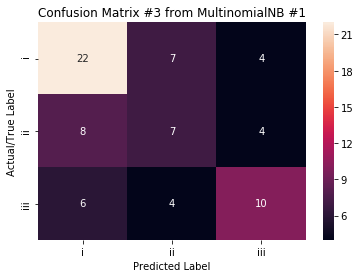

In [36]:
clfb_loaded_3.fit(rnaseq_x_hallmark_train, tumor_y_train_2)
tumor_y_pred = clfb_loaded_3.predict(rnaseq_x_hallmark_test)

plot_matrix(tumor_y_test_2, tumor_y_pred, 3, "MultinomialNB #1")

Let's also compare the cross validation and test set scores for all our iterations of feature extraction and model evaluation.

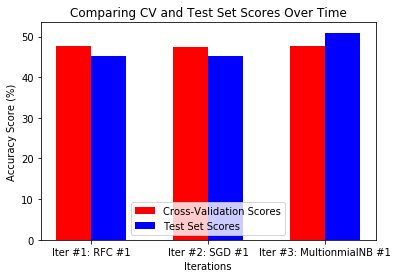

In [48]:
from matplotlib import pyplot as plt 

cv_scores = [grid_search_1_cv_score, grid_search_2_cv_score, grid_search_3_cv_score]
test_set_scores = [grid_search_1_test_set_score, grid_search_2_test_set_score, grid_search_3_test_set_score]

fig, ax = plt.subplots()
index = np.arange(len(cv_scores))
bar_width = 0.3
ax.bar(index, cv_scores, bar_width, color='r', label="Cross-Validation Scores")
ax.bar(index+bar_width, test_set_scores, bar_width, color='b', label="Test Set Scores")
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy Score (%)')
ax.set_title('Comparing CV and Test Set Scores Over Time')
ax.set_xticks(index + bar_width /2)
ax.set_xticklabels(['Iter #1: RFC #1', 'Iter #2: SGD #1', 'Iter #3: MultionmialNB #1'])
ax.legend()
plt.show()

So, now we can see in summary which models are the best to choose from. Remember, we need to choose a model which has the best generalization. That means, a model which can adapt well to any dataset (not just the test dataset we're dealing with) that you can give the model. Let's choose the last model, Multinomial NB, as the CV score is the same as the SGD model, but there is a better test-set score for that model in particular. We'll be using it for our conclusion.

Here, let's try to establish a relationship with the hallmark genes from the hallmark gene dictionary using the prediction function from our best performing model. We'll create a new dataframe that will contain the hallmark gene name, the sequence that is associated with that gene, its feature importance, and the predicted tumor stage. We'll have to make sure to sum up each feature importance and also drop the features from the initial dataframe all together, so we're left with the feature importances associated with that hallmark gene and the predicted cancer stages. Finally, we'll create a sankey graph to show all of these relationships. 

In [43]:
hallmark_gene_arr = []
for hallmark, arr in hallmark_dict.items(): 
    for gene in arr:
        if gene not in hallmark_gene_arr:
            hallmark_gene_arr.append(gene)

len(hallmark_gene_arr)

4384

In [0]:
from sklearn.preprocessing import MinMaxScaler
#need to scale it independently as we'll just be relying on the best performing model for establishing 
#a relationship between the hallmark genes and cancer stages 

scaler = MinMaxScaler(feature_range=(0, 1)) 
rnaseq_x_scaled = scaler.fit_transform(rnaseq_x)
rnaseq_x_scaled_df = pd.DataFrame(rnaseq_x_scaled, columns=rnaseq_x.columns)

In [45]:
rnaseq_x_important_df = feature_selector(hallmark_gene_arr, rnaseq_x_scaled_df)
rnaseq_x_important_df.head()

,ABCA1,ABCB8,ACAA2,ACADL,ACADM,ACADS,ACLY,ACO2,ACOX1,ADCY6,ADIG,ADIPOQ,ADIPOR2,AGPAT3,AIFM1,AK2,ALDH2,ALDOA,ANGPT1,ANGPTL4,APLP2,APOE,ARAF,ARL4A,ATL2,ATP1B3,BAZ2A,BCKDHA,BCL2L13,BCL6,C3,CAT,CCNG2,CD151,CD302,CD36,CDKN2C,CHCHD10,CHUK,CIDEA,...,FMO3,G6PC,GART,GCKR,GSS,GSTA3,GSTM4,GSTT2,HES6,HGFAC,HSD17B2,ITIH4,LCAT,LEAP2,LONP1,MAN1A1,MARCH6,MCCC2,MPP2,MTHFD1,NDRG2,NFS1,PGD,PGRMC1,PINK1,PTGDS,PTGR1,PYCR1,SAR1B,SERTAD1,SLC12A4,SLC22A1,SLC35B1,SLC46A3,SPINT2,SSR3,TAT,TTPA,UPB1,XDH
0,0.112687,0.244824,0.078362,0.001562,0.110534,0.055461,0.154196,0.044438,0.088356,0.462379,0.000000,0.0,0.044462,0.089493,0.224348,0.522482,0.072007,0.158206,0.103960,0.055616,0.132524,0.028749,0.121566,0.054222,0.120760,0.308798,0.572880,0.064124,0.336421,0.107969,0.188416,0.031602,0.273785,0.167536,0.022404,0.008626,0.126579,0.072634,0.385370,0.000000,...,0.008149,0.013308,0.181429,0.148601,0.291978,0.000000,0.000000,0.002653,0.099476,0.091214,0.090436,0.141358,0.005497,0.045287,0.228773,0.132101,0.154349,0.262480,0.001776,0.025551,0.049251,0.110994,0.151012,0.036188,0.144204,0.002201,0.078377,0.185072,0.233004,0.324395,0.112987,0.000340,0.129563,0.039149,0.011640,0.236940,0.001029,0.039581,0.124305,0.044273
1,0.123808,0.293219,0.223537,0.323790,0.263965,0.074630,0.197000,0.091618,0.216338,0.252733,0.085714,0.0,0.130969,0.459302,0.133433,0.422812,0.188774,0.076643,0.183168,0.001901,0.198249,0.067299,0.289094,0.023009,0.396201,0.156341,0.295771,0.101417,0.630424,0.120064,0.143990,0.305200,0.118412,0.111742,0.123387,0.049348,0.147067,0.118334,0.248869,0.000000,...,0.143489,0.015301,0.458214,0.406446,0.156987,0.006061,0.068844,0.028800,0.119721,0.000084,0.087449,0.118334,0.006376,0.113949,0.092511,0.216354,0.363005,0.318551,0.008881,0.167116,0.152670,0.357180,0.404919,0.267851,0.262870,0.000604,0.166251,0.002443,0.325494,0.053891,0.183333,0.118157,0.111668,0.079798,0.061180,0.290386,0.061697,0.121047,0.210980,0.168736
2,0.337608,0.183230,0.182895,0.510672,0.293309,0.068658,0.088642,0.069463,0.259667,0.436334,0.000000,0.0,0.297871,0.476952,0.237166,0.415018,0.389192,0.036772,0.202970,0.454340,0.181322,0.087772,0.282295,0.004802,0.466418,0.062536,0.445783,0.081590,0.483667,0.169157,0.616688,0.441115,0.255989,0.096115,0.275982,0.042940,0.058939,0.072859,0.389140,0.000000,...,0.138759,0.253582,0.171786,0.299406,0.092151,0.000000,0.111585,0.004277,0.018499,0.188664,0.092241,0.385410,0.308267,0.126752,0.115416,0.311845,0.256431,0.408521,0.003552,0.220309,0.181846,0.124145,0.065559,0.630001,0.427294,0.001043,0.132606,0.004398,0.477075,0.039432,0.314069,0.441643,0.102669,0.558996,0.006301,0.125110,0.259195,0.184084,0.205628,0.429494
3,0.180436,0.354037,0.168658,0.004685,0.287979,0.249829,0.182423,0.572977,0.268216,0.560450,0.000000,0.0,0.197999,0.653551,0.496592,0.225570,0.231784,0.089753,0.090759,0.094767,0.168779,0.199338,0.133805,0.037215,0.520014,0.045640,0.306875,0.260040,0.503657,0.102810,0.780287,0.170977,0.287474,0.035030,0.168734,0.021984,0.072130,0.198285,0.537707,0.000000,...,0.000231,0.226934,0.307500,0.123155,0.061386,0.000000,0.095154,0.000325,0.115183,0.620118,0.286692,0.137891,0.124157,0.314586,0.296860,0.358246,0.354226,0.490365,0.007105,0.186314,0.293429,0.645450,0.190259,0.421503,0.351567,0.000146,0.004955,0.131688,0.398024,0.038118,0.221645,0.123331,0.225483,0.096713,0.001635,0.406168,0.078347,0.025340,0.493415,0.692817
4,0.309464,0.182712,0.140735,0.476314,0.318310,0.235779,0.224890,0.064150,0.248125,0.216720,0.000000,0.0,0.307005,0.496366,0.089977,0.392986,0.275249,0.038208,0.064356,0.083231,0.170375,0.130072,0.206282,0.044418,0.532564,0.083511,0.311127,0.095005,0.437835,0.178762,0.564068,0.432811,0.158795,0.048988,0.242128,0.035693,0.027786,0.101544,0.470588,0.002515,...,0.145558,0.056640,0.226786,0.597455,0.062105,0.000000,0.057404,0.029450,0.046771,0.161539,0.059248,0.336699,0.269422,0.346433,0.154693,0.614038,0.318906,0.384606,0.007105,0.114473,0.213430,0.152025,0.091822,0.249900,0.215983,0.000046,0.096775,0.037503,0.353360,0.046004,0.27

In [46]:
from sklearn.model_selection import train_test_split
rnaseq_x_important_train, rnaseq_x_important_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x_important_df, np.array(tumor_y),
                                                                                 random_state=np.random.seed(0))
rfcb_loaded_feature_importances = rfcb_loaded.fit(rnaseq_x_important_train, tumor_y_train).feature_importances_
clf_best_fit = clfb_loaded_3.fit(np.array(rnaseq_x_important_train), np.ravel(tumor_y_train))
rnaseq_x_important_test_fixed = rnaseq_x_important_test.reset_index(drop=True)


prediction_features_dict = {}
for i in range(len(rnaseq_x_important_test)):
  clf_best_prediction = clf_best_fit.predict(rnaseq_x_important_test_fixed.loc[i,:].values.reshape(1, -1))
  print("Iteration: {}".format(i))
  print("Prediction Label: {}".format(clf_best_prediction))
  feature_importances_arr = []
  for feature_importance, feature in zip(rfcb_loaded_feature_importances, rnaseq_x_important_df.columns):
      feature_importances_arr.append((feature, feature_importance))
  sorted_feature_importances_arr = sorted(feature_importances_arr, key=lambda x: x[1])
  prediction_features_dict[clf_best_prediction[0]] = sorted_feature_importances_arr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Iteration: 0
Prediction Label: ['i']
Iteration: 1
Prediction Label: ['i']
Iteration: 2
Prediction Label: ['i']
Iteration: 3
Prediction Label: ['i']
Iteration: 4
Prediction Label: ['i']
Iteration: 5
Prediction Label: ['i']
Iteration: 6
Prediction Label: ['iii']
Iteration: 7
Prediction Label: ['not_reported']
Iteration: 8
Prediction Label: ['ii']
Iteration: 9
Prediction Label: ['i']
Iteration: 10
Prediction Label: ['i']
Iteration: 11
Prediction Label: ['ii']
Iteration: 12
Prediction Label: ['i']
Iteration: 13
Prediction Label: ['i']
Iteration: 14
Prediction Label: ['i']
Iteration: 15
Prediction Label: ['i']
Iteration: 16
Prediction Label: ['i']
Iteration: 17
Prediction Label: ['ii']
Iteration: 18
Prediction Label: ['i']
Iteration: 19
Prediction Label: ['i']
Iteration: 20
Prediction Label: ['i']
Iteration: 21
Prediction Label: ['ii']
Iteration: 22
Prediction Label: ['i']
Iteration: 23
Prediction Label: ['i']
Iteration: 24
Prediction Label: ['i']
Iteration: 25
Prediction Label: ['i']
Itera

In [47]:
hallmark_rnaseq_importance_prediction = []

for prediction, rnaseq_arr in prediction_features_dict.items():
  for rnaseq in rnaseq_arr:   
    for hallmark_gene in hallmark_dict.keys():
      if rnaseq[0] in hallmark_dict[hallmark_gene]:
        hallmark_rnaseq_importance_prediction_tuple = (hallmark_gene, rnaseq[0], rnaseq[1], prediction)
        hallmark_rnaseq_importance_prediction.append(hallmark_rnaseq_importance_prediction_tuple)
      


hallmark_gene_prediction_df = pd.DataFrame(hallmark_rnaseq_importance_prediction, columns=['hallmark_gene', 'rna_seq', 
                                                                                             'rna_feature_importance', 
                                                                                             'prediction'])
hallmark_gene_prediction_df.head()

,hallmark_gene,rna_seq,rna_feature_importance,prediction
0,HALLMARK_ALLOGRAFT_REJECTION,IL9,0.0,i
1,HALLMARK_APICAL_JUNCTION,KRT31,0.0,i
2,HALLMARK_ESTROGEN_RESPONSE_EARLY,SOX3,0.0,i
3,HALLMARK_ESTROGEN_RESPONSE_LATE,SOX3,0.0,i
4,HALLMARK_HEME_METABOLISM,GYPB,0.0,i


In [0]:
hallmark_gene_prediction_sums = hallmark_gene_prediction_df.groupby(['hallmark_gene', 'prediction']).sum()
hallmark_gene_prediction_sums = hallmark_gene_prediction_sums.reset_index()

In [0]:
hallmark_gene_prediction_sums_final = hallmark_gene_prediction_sums.pivot(index="hallmark_gene", columns="prediction", values="rna_feature_importance")
hallmark_gene_prediction_sums_final.head()

prediction,i,ii,iii
hallmark_gene,,,
HALLMARK_ADIPOGENESIS,0.044823,0.044823,0.044823
HALLMARK_ALLOGRAFT_REJECTION,0.042333,0.042333,0.042333
HALLMARK_ANDROGEN_RESPONSE,0.022068,0.022068,0.022068
HALLMARK_ANGIOGENESIS,0.008922,0.008922,0.008922
HALLMARK_APICAL_JUNCTION,0.040554,0.040554,0.040554


In [0]:
import itertools
import plotly.graph_objects as go


predictors = ['i', 'ii', 'iii']*50
predictors1 = [1, 2, 3]*50
hallmark_gene_arr3 = list(hallmark_gene_prediction_sums_final.index)
label_arr = predictors + predictors1
source_arr = [[label_arr.index(i) for _ in range(3)] for i in label_arr[:150]] 
source_flattened = list(itertools.chain.from_iterable(source_arr))
target_arr = [label_arr.index(i) for i in label_arr[150:]]*3

value_arr = list(hallmark_gene_prediction_sums_final['i'].values)
fig = go.Figure(data=[go.Sankey(
                      node = dict(
                          pad = 15,
                          thickness = 15,
                          label = label_arr
                      ),
                      link = dict(
                          source = source_flattened,
                          target = target_arr,
                          value = value_arr,
                          label = hallmark_gene_arr3
                      ))])

fig.show()

Now, we can see how the changes between the hallmark genes change over time at each prediction. 

This has been a journey of data exploration and building relationships with our dataset and our target dataset. The models didn't perform the well, but this had to do with the quality of the data itself. The RNA sequences didn't have any correlated features alone. With the association with the hallmark genes, we do start to see stronger relationship with the hallmark genes and the RNA sequences from out dataset, as we see that the last model performed the best.  